# Laboratorio 5

Daniel Alfredo Rayo Roldán

Gerardo Gabriel Pineda Riveiro

Github: https://github.com/DanielRasho/DS-Lab4

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo
import re
from pathlib import Path
import pandas as pd
from prophet import Prophet

/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Cargado de Datos

In [2]:
def cyanobacteria_index(path, show_rgb=False):
    with rasterio.open(path) as ds:
        arr = ds.read().astype(np.float32)  # shape: (bands, height, width)

    # Sentinel-2 band order assumption:
    # arr[0] = B01, arr[1] = B02, ..., arr[11] = B12
    # The script uses: B02, B03, B04, B05, B07, B08, B8A, B11, B12
    B02 = arr[1]
    B03 = arr[2]
    B04 = arr[3]
    B05 = arr[4]
    B07 = arr[6]
    B08 = arr[7]
    B8A = arr[8]
    B11 = arr[10]
    B12 = arr[11]

    MNDWI_threshold = 0.42
    NDWI_threshold = 0.4
    filter_UABS = True

    def wbi(r, g, b, nir, swir1, swir2):
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)
        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        # wii, wri, puwi, uwi, usi are not used in filtering
        ws = (
            (mndwi > MNDWI_threshold)
            | (ndwi > NDWI_threshold)
            | (aweinsh > 0.1879)
            | (aweish > 0.1112)
            | (ndvi < -0.2)
            | (ndwi_leaves > 1)
        )
        if filter_UABS:
            ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))
        return ws.astype(np.uint8)

    water = wbi(B04, B03, B02, B08, B11, B12)

    # Floating vegetation index
    def FAI(a, b, c):
        return b - a - (c - a) * (783 - 665) / (865 - 665)

    FAIv = FAI(B04, B07, B8A)

    # NDCI and chlorophyll
    def NDCI(a, b):
        return (b - a) / (b + a)

    NDCIv = NDCI(B04, B05)
    

    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071
    
    if show_rgb:
        # Output RGB image
        rgb = np.zeros((3, arr.shape[1], arr.shape[2]), dtype=np.float32)

        # True color (non-water)
        true_color = np.stack((3 * B04, 3 * B03, 3 * B02))
        mask_nonwater = water == 0
        rgb[:, mask_nonwater] = true_color[:, mask_nonwater]

        # Floating vegetation
        mask_fai = (water == 1) & (FAIv > 0.08)
        rgb[:, mask_fai] = np.array([233/255, 72/255, 21/255])[:, None]

        # Chlorophyll ranges
        chl_ranges = [
            (0.5, [0, 0, 1.0]),
            (1,   [0, 0, 1.0]),
            (2.5, [0, 59/255, 1]),
            (3.5, [0, 98/255, 1]),
            (5,   [15/255, 113/255, 141/255]),
            (7,   [14/255, 141/255, 120/255]),
            (8,   [13/255, 141/255, 103/255]),
            (10,  [30/255, 226/255, 28/255]),
            (14,  [42/255, 226/255, 28/255]),
            (18,  [68/255, 226/255, 28/255]),
            (20,  [68/255, 226/255, 28/255]),
            (24,  [134/255, 247/255, 0]),
            (28,  [140/255, 247/255, 0]),
            (30,  [205/255, 237/255, 0]),
            (38,  [208/255, 240/255, 0]),
            (45,  [208/255, 240/255, 0]),
            (50,  [251/255, 210/255, 3/255]),
            (75,  [248/255, 207/255, 2/255]),
            (90,  [134/255, 247/255, 0]),
            (100, [245/255, 164/255, 9/255]),
            (150, [240/255, 159/255, 8/255]),
            (250, [237/255, 157/255, 7/255]),
            (300, [239/255, 118/255, 15/255]),
            (350, [239/255, 101/255, 15/255]),
            (450, [239/255, 100/255, 14/255]),
            (500, [233/255, 72/255, 21/255]),
        ]

        mask_remaining = (water == 1) & ~(FAIv > 0.08)
        for limit, color in chl_ranges:
            mask = mask_remaining & (chl < limit)
            rgb[:, mask] = np.array(color)[:, None]
            mask_remaining &= ~(chl < limit)

        # Above max threshold
        rgb[:, mask_remaining] = np.array([233/255, 72/255, 21/255])[:, None]

        return rgb
    else:
        output = np.full_like(chl, np.nan, dtype=np.float32)

        mask_floating_veg = water & (FAIv > 0.08)
        mask_chl = water & ~mask_floating_veg

        # Replace inf/-inf but preserve NaNs
        chl = np.nan_to_num(chl, nan=np.nan, posinf=np.nan, neginf=np.nan)

        H, W = chl.shape
        block = 512  # adjust to fit RAM

        for i in range(0, H, block):
            for j in range(0, W, block):
                slice_i = slice(i, min(i + block, H))
                slice_j = slice(j, min(j + block, W))
                mask_block = mask_chl[slice_i, slice_j]
                # assign clipped values
                output[slice_i, slice_j][mask_block] = np.clip(
                    chl[slice_i, slice_j][mask_block], 0, 500
                )

        return output

In [3]:
def water_quality_index(path, show=False):
    # ---------------------------
    # Bands scales
    # ---------------------------
    scaleChl_a = [0, 6, 12, 20, 30, 50]
    scaleCya   = [0, 10, 20, 40, 50, 100]
    scaleTurb  = [0, 4, 8, 12, 16, 20]
    scaleCDOM  = [0, 1, 2, 3, 4, 5]
    scaleDOC   = [0, 5, 10, 20, 30, 40]
    scaleColor = [0, 10, 20, 30, 40, 50]

    def normalize(value, scale):
        min_val, max_val = scale[0], scale[-1]
        norm = (value - min_val) / (max_val - min_val + 1e-10)
        return np.clip(norm, 0, 1)

    def nd_index(a, b):
        return (a - b) / (a + b + 1e-10)

    # ---------------------------
    # Read image bands
    # ---------------------------
    with rasterio.open(path) as ds:
        arr = ds.read().astype(np.float32)  # shape: (bands, height, width)

        # Assuming bands order: B01=0, B02=1, B03=2, B04=3, B08=4
        B01 = arr[0]
        B02 = arr[1]
        B03 = arr[2]
        B04 = arr[3]
        B08 = arr[4]

        # ---------------------------
        # Compute water-land mask
        # ---------------------------
        NDWI = nd_index(B03, B08)

        # ---------------------------
        # Compute water quality parameters
        # ---------------------------
        Chl_a = 4.26 * (B03 / B01)**3.94
        Cya   = 115530.31 * ((B03 * B04) / B02)**2.38
        Turb  = 8.93 * (B03 / B01) - 6.39
        CDOM  = 537 * np.exp(-2.93 * B03 / B04)
        DOC   = 432 * np.exp(-2.24 * B03 / B04)
        Color = 25366 * np.exp(-4.53 * B03 / B04)

        # ---------------------------
        # Normalize
        # ---------------------------
        norm_Chl_a = normalize(Chl_a, scaleChl_a)
        norm_Cya   = normalize(Cya, scaleCya)
        norm_Turb  = normalize(Turb, scaleTurb)
        norm_CDOM  = normalize(CDOM, scaleCDOM)
        norm_DOC   = normalize(DOC, scaleDOC)
        norm_Color = normalize(Color, scaleColor)

        # ---------------------------
        # Combine into a single index
        # ---------------------------
        index_combined = (norm_Chl_a + norm_Cya + norm_Turb +
                          norm_CDOM + norm_DOC + norm_Color) / 6.0

        # Mask land pixels
        index_combined[NDWI < 0] = np.nan

        # ---------------------------
        # Optional display
        # ---------------------------
        if show:
            plt.imshow(index_combined, cmap="viridis")
            plt.colorbar(label="Water Quality Index (0-1)")
            plt.title("Unified Water Quality Index")
            plt.show()

        return index_combined

In [4]:
amatitlan_images = {
    '2025-01-13': 'cianobacteria_amatitlan-2025-01-13.tif',    
    '2025-01-18': 'cianobacteria_amatitlan-2025-01-18.tif',    
    '2025-02-07': 'cianobacteria_amatitlan-2025-02-07.tif',    
    '2025-03-04': 'cianobacteria_amatitlan-2025-03-04.tif',    
    '2025-03-19': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-03-24': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-04-13': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-04-15': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-04-18': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-06-14': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-07-17': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-07-22': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-08-01': 'cianobacteria_amatitlan-2025-03-19.tif',
    '2025-08-13': 'cianobacteria_amatitlan-2025-03-19.tif',
}

atitlan_images = {
    '2025-01-13': 'cianobacteria_amatitlan-2025-01-13.tif',
    '2025-01-18': 'cianobacteria_amatitlan-2025-01-18.tif',
    '2025-01-28': 'cianobacteria_amatitlan-2025-01-28.tif',
    '2025-02-02': 'cianobacteria_amatitlan-2025-02-02.tif',
    '2025-02-07': 'cianobacteria_amatitlan-2025-02-07.tif',
    '2025-03-04': 'cianobacteria_amatitlan-2025-03-04.tif',
    '2025-03-09': 'cianobacteria_amatitlan-2025-03-09.tif',
    '2025-03-14': 'cianobacteria_amatitlan-2025-03-14.tif',
    '2025-04-03': 'cianobacteria_amatitlan-2025-04-03.tif',
    '2025-04-13': 'cianobacteria_amatitlan-2025-04-13.tif',
    '2025-04-15': 'cianobacteria_amatitlan-2025-04-15.tif',
    '2025-05-13': 'cianobacteria_amatitlan-2025-05-13.tif',
    '2025-07-12': 'cianobacteria_amatitlan-2025-07-12.tif',
    '2025-07-24': 'cianobacteria_amatitlan-2025-07-24.tif',
    '2025-08-13': 'cianobacteria_amatitlan-2025-08-13.tif',
}

In [5]:
dates = []
cianobacteria = []
contamination = []

def getIndexPerDate(basepath, selected_images):
    results = {}
    for date, fname in selected_images.items():
        tif_path = basepath / fname
        with rasterio.open(tif_path) as ds:
            chl_map = cyanobacteria_index(tif_path)
            mean_chl = np.nanmean(chl_map)
            contamination_map = water_quality_index(tif_path)
            mean_contamination = np.nanmean(contamination_map)
            cianobacteria.append(mean_chl)
            contamination.append(mean_contamination)
            dates.append(date)

getIndexPerDate(Path("./data/GIS/"), amatitlan_images)

amatitlan_df = pd.DataFrame.from_dict({'Fecha': dates, 'Indice': cianobacteria, "Contamination": contamination})

/tmp/ipykernel_47048/259501005.py:23: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - r) / (nir + r)
/tmp/ipykernel_47048/259501005.py:25: RuntimeWarning: divide by zero encountered in divide
  ndwi = (g - nir) / (g + nir)
/tmp/ipykernel_47048/259501005.py:26: RuntimeWarning: divide by zero encountered in divide
  ndwi_leaves = (nir - swir1) / (nir + swir1)
/tmp/ipykernel_47048/3403634514.py:41: RuntimeWarning: divide by zero encountered in divide
  Chl_a = 4.26 * (B03 / B01)**3.94
/tmp/ipykernel_47048/3403634514.py:41: RuntimeWarning: invalid value encountered in power
  Chl_a = 4.26 * (B03 / B01)**3.94
/tmp/ipykernel_47048/3403634514.py:42: RuntimeWarning: divide by zero encountered in divide
  Cya   = 115530.31 * ((B03 * B04) / B02)**2.38
/tmp/ipykernel_47048/3403634514.py:42: RuntimeWarning: invalid value encountered in power
  Cya   = 115530.31 * ((B03 * B04) / B02)**2.38
/tmp/ipykernel_47048/3403634514.py:43: RuntimeWarning: divide by zero encountered in divi

In [6]:
dates = []
cianobacteria = []
contamination = []

def getIndexPerDate(basepath, selected_images):
    results = {}
    for date, fname in selected_images.items():
        tif_path = basepath / fname
        with rasterio.open(tif_path) as ds:
            chl_map = cyanobacteria_index(tif_path)
            mean_chl = np.nanmean(chl_map)
            contamination_map = water_quality_index(tif_path)
            mean_contamination = np.nanmean(contamination_map)
            cianobacteria.append(mean_chl)
            contamination.append(mean_contamination)
            dates.append(date)

getIndexPerDate(Path("./data/GISATI/"), atitlan_images)

atitlan_df = pd.DataFrame.from_dict({'Fecha': dates, 'Indice': cianobacteria, "Contamination": contamination})

/tmp/ipykernel_47048/259501005.py:23: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - r) / (nir + r)
/tmp/ipykernel_47048/259501005.py:23: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - r) / (nir + r)
/tmp/ipykernel_47048/259501005.py:24: RuntimeWarning: divide by zero encountered in divide
  mndwi = (g - swir1) / (g + swir1)
/tmp/ipykernel_47048/259501005.py:25: RuntimeWarning: divide by zero encountered in divide
  ndwi = (g - nir) / (g + nir)
/tmp/ipykernel_47048/259501005.py:26: RuntimeWarning: divide by zero encountered in divide
  ndwi_leaves = (nir - swir1) / (nir + swir1)
/tmp/ipykernel_47048/259501005.py:26: RuntimeWarning: invalid value encountered in divide
  ndwi_leaves = (nir - swir1) / (nir + swir1)
/tmp/ipykernel_47048/259501005.py:29: RuntimeWarning: divide by zero encountered in divide
  dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
/tmp/ipykernel_47048/259501005.py:53: RuntimeWarning: divide by zero encountered in divide
  return 

In [9]:
amatitlan_df

,Fecha,Indice,Contamination
0,2025-01-13,31.598320,0.607337
1,2025-01-18,29.416487,0.611615
2,2025-02-07,28.357479,0.609827
3,2025-03-04,20.535675,0.681984
4,2025-03-19,14.831296,0.551836
5,2025-03-24,14.831296,0.551836
6,2025-04-13,14.831296,0.551836
7,2025-04-15,14.831296,0.551836
8,2025-04-18,14.831296,0.551836
9,2025-06-14,14.831296,0.551836


In [8]:
atitlan_df

,Fecha,Indice,Contamination
0,2025-01-13,50.685703,0.210186
1,2025-01-18,75.395752,0.266005
2,2025-01-28,63.253490,0.281620
3,2025-02-02,54.408424,0.238580
4,2025-02-07,58.416462,0.274652
5,2025-03-04,20.129957,0.391104
6,2025-03-09,15.174212,0.353368
7,2025-03-14,25.146950,0.280939
8,2025-04-03,17.417360,0.396244
9,2025-04-13,35.227100,0.296648


# Modelos Temporales

19:55:30 - cmdstanpy - INFO - Chain [1] start processing


19:55:30 - cmdstanpy - INFO - Chain [1] done processing
/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


           ds       yhat  yhat_lower  yhat_upper
0  2025-01-13  22.543852   17.046819   27.927112
1  2025-01-18  23.202758   18.240331   28.751122
2  2025-02-07  20.425769   14.851022   25.535362
3  2025-03-04  15.784101   10.795838   20.507756
4  2025-03-19  15.410703   10.169830   20.961059
5  2025-03-24  18.156006   12.870616   23.721091
6  2025-04-13  10.798103    6.006679   16.143044
7  2025-04-15  13.151393    7.954235   18.229176
8  2025-04-18  16.037924   10.716387   21.048255
9  2025-06-14  13.988283    8.651799   19.222863
10 2025-07-17  10.808089    5.521310   16.188492
11 2025-07-22   7.008410    2.248871   12.487931
12 2025-08-01   9.456156    4.117348   14.606945
13 2025-08-13   6.196227    1.258482   11.839992
14 2025-08-31   2.022412   -3.117209    7.317085
15 2025-09-30   2.620565   -2.811524    7.561736
16 2025-10-31   3.751957   -1.356472    8.589919
17 2025-11-30  -3.681787   -8.743978    1.491606
18 2025-12-31  -2.579463   -7.611454    2.957502


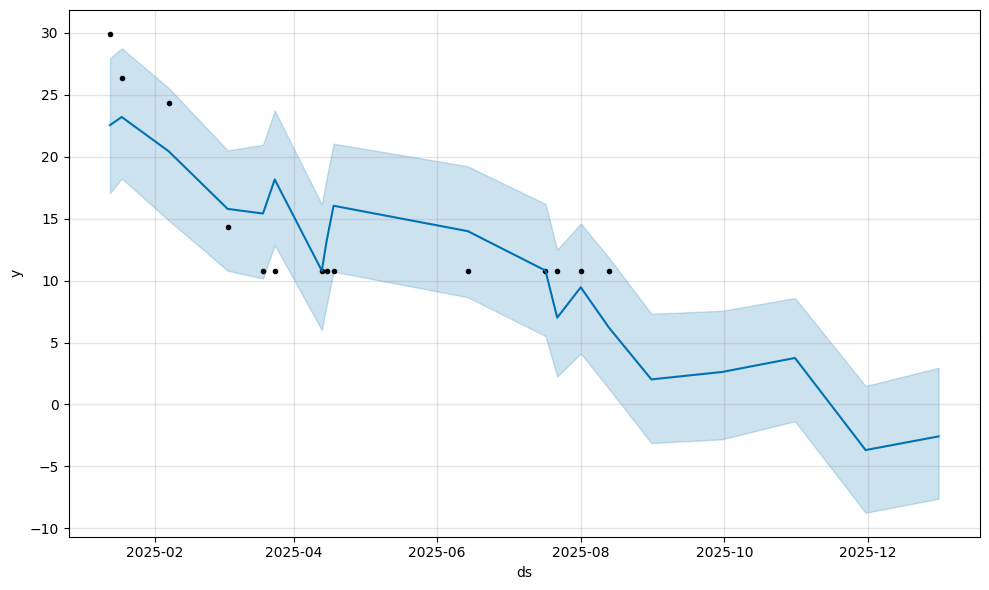

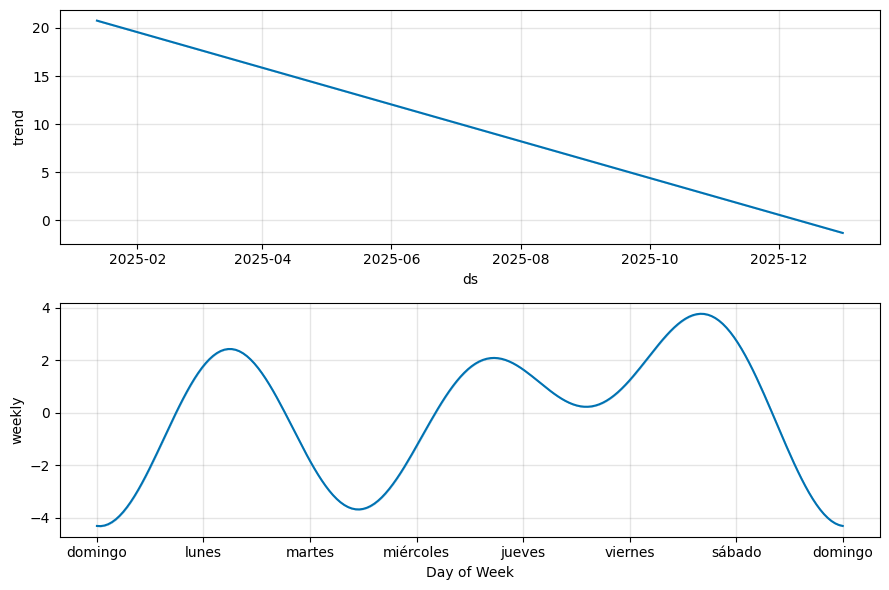

In [ ]:
# Ensure date is datetime
amatitlan_df["Fecha"] = pd.to_datetime(amatitlan_df["Fecha"])

# Rename columns for Prophet
df_prophet = amatitlan_df.rename(columns={"Fecha": "ds", "Indice": "y"})

# Create and fit the model
model = Prophet()
model.fit(df_prophet)

# Create a future dataframe (e.g., forecast for next 30 days)
future = model.make_future_dataframe(periods=5, freq='M')  # daily frequency by default
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)